<a href="https://colab.research.google.com/github/ismailnajah/Gender_Prediction_from_handwritting_using_CNN_model/blob/main/CNN_Model_gender_prediction_from_handwritting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepLearning aproche for gender prediction from handwriting images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
from tqdm import tqdm
from sklearn.feature_extraction import image
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc
from keras.models import model_from_json

## Utility functions

In [2]:
def crop_image(img,tol=240):
    mask = img<tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def show_img(img,title=''):
    plt.figure(figsize=[8,4])
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

def show_grid_imgs(data,n):
    plt.figure(figsize=(6,6))
    for i in range(0,n*n):
        plt.subplot(n,n,i+1)
    plt.imshow(data[random.randint(0,len(data))],cmap='gray')
    plt.show()

def resize(img,h):
    fixed_height = h
    height_percent = (fixed_height / float(img.shape[0]))
    width_size = int((float(img.shape[1]) * float(height_percent)))
    img = cv2.resize(img,(width_size, fixed_height))
    return img

def get_image(id,folder):
    path = os.path.join(DATADIR, f"{folder}/{id}.jpg")
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img_array


def sklearn_patches(img,window_size,nb_patches):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,tg = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    src_img = crop_image(tg)
    if src_img.shape[0] <= window_size[0]:
        src_img = resize(src_img,10+window_size[0])
    patches = image.extract_patches_2d(
      src_img, 
      patch_size=window_size,
      max_patches=nb_patches,
      random_state=np.random.RandomState(round(time.time()))
  )
    return patches

def load_data(csv_file,category):
    X=[]
    y=[]
    for entry in tqdm(csv_file):
        img_array = cv2.resize(get_image(f'image_{entry[0]}',category),IMG_SIZE)
        X.append(img_array)
        y.append(entry[1])
    X = np.array(X).reshape( -1, IMG_SIZE[0], IMG_SIZE[1], 1)
    X = X/255.0
    y = np.array(y)
    return X,y

## Creating Training Dataset

In [3]:
DATADIR = '' #path to google drive dataset
train_csv_path = 'Train/GT_2B_Training.csv'
val_csv_path = 'Validation/GT_2B_Validation.csv'
out_dir = 'Datagen'

In [4]:
test_csv_path = 'Test/GT_2B_Test.csv'

Cleaning original image example

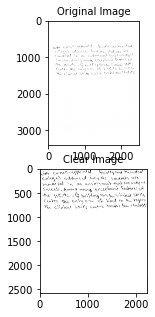

In [5]:
original = get_image('Image_75','Train')
blur = cv2.GaussianBlur(original,(5,5),0)
ret3,tg = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
clean_image = crop_image(tg)
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Original Image',fontsize=10)
plt.imshow(original,cmap='gray')
plt.subplot(2,1,2)
plt.title('Clear Image',fontsize=10)
plt.imshow(clean_image,cmap='gray')

plt.show()

### ImageDatagenerator

This section illustrates the data preprocessing steps, first we load each image that contatins the full paragraph and we slice it into multiple pieces (using sklearn_patches function defined above) that contains chuncks of handwriten text.  

In [6]:
IMG_SIZE = (200,200)
window_size = (800,800)
npatches = 200

def generate_datagen(csv_file_path,category):
    id=1
    csv_file = pd.read_csv(csv_file_path,sep=';').to_numpy()
    for entry in tqdm(csv_file):
        #read the image
        img = get_image(f'Image_{entry[0]}',category)
        label = entry[1]
        patches = sklearn_patches(img, window_size, npatches)
        for p in patches:
            #p = cv2.bitwise_not(p)
            gender = 'Male'
            if label == 0:
                gender= 'Female'
            path = f'{out_dir}/{category}/{gender}/image_{id}.jpg'
      
            #resize image
            p = cv2.resize(p,IMG_SIZE)
            cv2.imwrite(path, p)
            id += 1

In [7]:
a = get_image(f'Image_{1}','Train')

In [9]:
print(a)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [246 249 250 ... 255 255 255]
 [249 249 249 ... 255 255 255]
 [245 242 242 ... 255 255 255]]


creating generated data folders

In [ ]:
generate_datagen(train_csv_path,'Train')
generate_datagen(val_csv_path,'Validation')

 28%|██▊       | 306/1100 [01:19<03:35,  3.68it/s]

In [ ]:
generate_datagen(test_csv_path,'Test')

In [8]:
batch_size = 32
datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.5,
        fill_mode='wrap')

train_generator = datagen.flow_from_directory(
        'Datagen/Train',  # this is the target directory
        target_size=(200, 200),  # all images will be resized to 200x200
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='binary')


validation_generator = datagen.flow_from_directory(
        'Datagen/Validation',  # this is the target directory
        target_size=(200, 200),  # all images will be resized to 200x200
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='binary')

Found 220000 images belonging to 2 classes.
Found 80000 images belonging to 2 classes.


### Data Visualisation

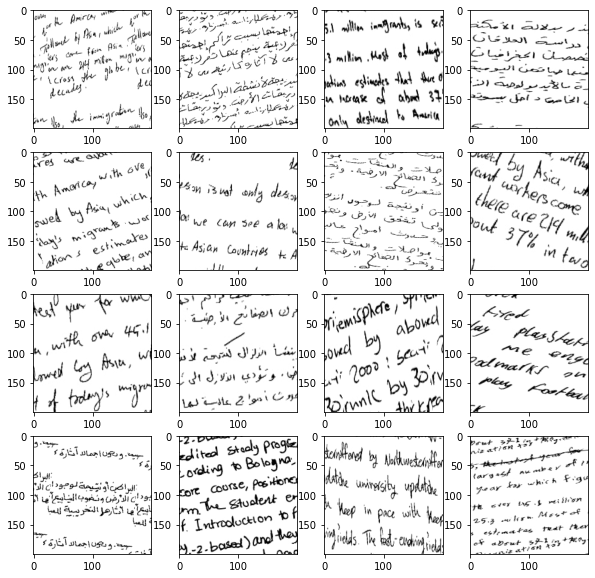

In [12]:
plt.figure(figsize=(10,10))
n = 4
for i in range(0,n*n):
  batch = train_generator.next()
  image_ = batch[0][0].astype('float32')
  image_ = np.array(image_).reshape(IMG_SIZE[0], IMG_SIZE[1])
  plt.subplot(n,n,i+1)
  plt.imshow(image_,cmap='gray')
plt.show()

## Building and Training the CNN Model


### CNN model

In [9]:
input_shape = (IMG_SIZE[0],IMG_SIZE[1],1)

def create_model():
    model = tf.keras.models.Sequential([
        #first layer
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),
      
        #second convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),
        
        #third layer
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.6),
        
        #fourth layer
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.6),
        
        #fifth layer
        #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #tf.keras.layers.MaxPooling2D(2,2),

        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        
        # 512 neuron hidden layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        # Only 1 output neuron.(1 male, 0 female)
        tf.keras.layers.Dense(1, activation='sigmoid')])
    return model


#,kernel_regularizer=regularizers.l2(0.0001)

In [10]:
from tensorflow.keras import optimizers
model = create_model()
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=5e-4), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 128)       0

C:\Users\minki\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Training the model

In [11]:
t_history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks = [EarlyStopping(monitor='val_accuracy', patience=5)]
        )

Epoch 1/30
6875/6875 [==============================] - 932s 135ms/step - loss: 0.6517 - accuracy: 0.6130 - val_loss: 0.6554 - val_accuracy: 0.6381
Epoch 2/30
6875/6875 [==============================] - 901s 131ms/step - loss: 0.6275 - accuracy: 0.6531 - val_loss: 0.6332 - val_accuracy: 0.6617
Epoch 3/30
6875/6875 [==============================] - 918s 134ms/step - loss: 0.6232 - accuracy: 0.6586 - val_loss: 0.6390 - val_accuracy: 0.6656
Epoch 4/30
6875/6875 [==============================] - 907s 132ms/step - loss: 0.6180 - accuracy: 0.6639 - val_loss: 0.6602 - val_accuracy: 0.6046
Epoch 5/30
6875/6875 [==============================] - 909s 132ms/step - loss: 0.6191 - accuracy: 0.6628 - val_loss: 0.6440 - val_accuracy: 0.6480
Epoch 6/30
6875/6875 [==============================] - 922s 134ms/step - loss: 0.6206 - accuracy: 0.6628 - val_loss: 0.6509 - val_accuracy: 0.6428
Epoch 7/30
6875/6875 [==============================] - 952s 138ms/step - loss: 0.6201 - accuracy: 0.6640 - val_

#### Training Results


Text(0.5, 1.0, 'Loss Curves')

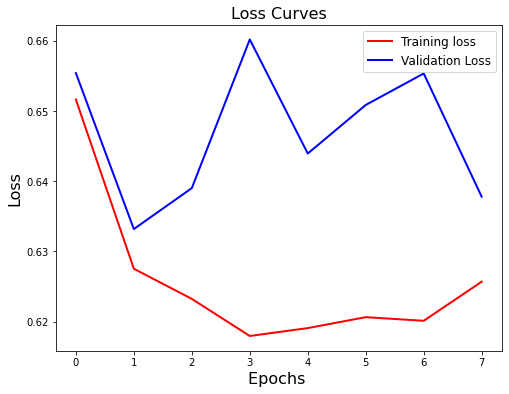

In [12]:
plt.figure(figsize=[8,6])
plt.plot(t_history.history['loss'],'r',linewidth=2.0)
plt.plot(t_history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

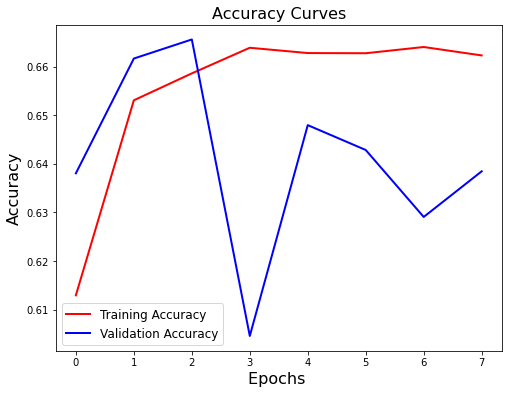

In [13]:
plt.figure(figsize=[8,6])
plt.plot(t_history.history['accuracy'],'r',linewidth=2.0)
plt.plot(t_history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Test

In [14]:
test_y = pd.read_csv('test_answers.csv')
test_y = test_y['male']
test_y = test_y[93:]
test_y.shape

(100,)

In [15]:
test_generator = datagen.flow_from_directory(
        'Datagen/Test',  # this is the target directory
        target_size=(200, 200),  # all images will be resized to 200x200
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='binary')

Found 80000 images belonging to 2 classes.


In [16]:
test_hist = model.evaluate(test_generator)

2500/2500 [==============================] - 238s 95ms/step - loss: 0.6180 - accuracy: 0.6870


In [17]:
test_hist

[0.6180436611175537, 0.6870250105857849]

In [19]:
preds = model.predict_generator(test_generator)

<ipython-input-19-503587385f9f>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


In [31]:
preds.shape

(80000, 1)

In [32]:
preds[:100]

array([[0.39628834],
       [0.42541134],
       [0.37897408],
       [0.44491902],
       [0.44731426],
       [0.49030805],
       [0.31650162],
       [0.5225479 ],
       [0.49412796],
       [0.4023669 ],
       [0.49519807],
       [0.3702761 ],
       [0.44926012],
       [0.35428223],
       [0.36592025],
       [0.41874215],
       [0.6251037 ],
       [0.35248405],
       [0.5129226 ],
       [0.39274856],
       [0.5562375 ],
       [0.50149125],
       [0.3940786 ],
       [0.49030805],
       [0.44552583],
       [0.5595428 ],
       [0.5835427 ],
       [0.359931  ],
       [0.31567693],
       [0.5147689 ],
       [0.5775213 ],
       [0.48834768],
       [0.4022829 ],
       [0.5666634 ],
       [0.50188464],
       [0.4902244 ],
       [0.3922114 ],
       [0.49163806],
       [0.40689605],
       [0.4206297 ],
       [0.5272972 ],
       [0.40307847],
       [0.3708232 ],
       [0.5212697 ],
       [0.6291385 ],
       [0.4194637 ],
       [0.478486  ],
       [0.576

In [48]:
answer = []
sum = 0
for i , v in enumerate(preds):
    sum += v
    if (i+1)%800 == 0:
        sum = sum/800
        answer.append(sum)
        sum = 0
answer = np.array(answer)
print(answer.shape,test_y.shape)

(100, 1) (100,)


In [50]:
answer[:20]

array([[0.44817543],
       [0.45728484],
       [0.4524811 ],
       [0.45197368],
       [0.4587207 ],
       [0.46048814],
       [0.45308796],
       [0.457265  ],
       [0.45883068],
       [0.45687085],
       [0.45505115],
       [0.45453236],
       [0.4575793 ],
       [0.45125934],
       [0.45197567],
       [0.45494366],
       [0.45464042],
       [0.44641456],
       [0.45386875],
       [0.4556655 ]], dtype=float32)

In [36]:
from sklearn.metrics import log_loss
print('Log_loss:', log_loss(test_y, answer))

Log_loss: 0.6794660568237305


In [37]:
answer_label = list(map(lambda x: 1 if x>=0.5 else 0,answer))

In [38]:
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(test_y, answer_label)*100, '%')

Accuracy: 60.0 %


In [52]:
test_y_800 = []
for i in test_y:
    for j in range(800):
        test_y_800.append(i)
len(test_y_800)

80000

In [53]:
preds_label = list(map(lambda x: 1 if x>=0.5 else 0,preds))

In [54]:
print('Accuracy:', accuracy_score(test_y_800, preds_label)*100, '%')

Accuracy: 54.07375 %


In [55]:
from sklearn.metrics import log_loss
print('Log_loss:', log_loss(test_y_800 ,preds))

Log_loss: 0.7011936578421853


Efficientent

In [ ]:
model_ef = tf.keras.applications.efficientnet.EfficientNetB7()

얘는 벨리데이션으로 테스트????? 밑에는 무시

load validation data

In [56]:
validation = datagen.flow_from_directory(
            'Datagen/Validation',  # this is the target directory
            target_size=IMG_SIZE,  # all images will be resized to 200x200
            batch_size=10000,
            color_mode="grayscale",
            class_mode='binary')


Found 40000 images belonging to 2 classes.


In [57]:
X_val , y_val = validation.next()

In [58]:
print(len(X_val))

10000


In [59]:
preds = model.predict(X_val,verbose=1)

313/313 [==============================] - 2s 6ms/step


In [60]:
preds

array([[0.54645467],
       [0.43449262],
       [0.33208868],
       ...,
       [0.5734903 ],
       [0.56428504],
       [0.5402373 ]], dtype=float32)

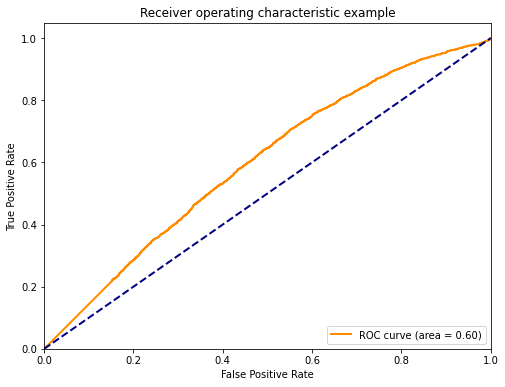

In [61]:
fpr, tpr, _ = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[8,6])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Save and Load models

In [66]:
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

In [67]:
# serialize model to JSON
model_json = model.to_json()
with open(f"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5model.save_weights(f"{path}/model_{version}.h5")
print("Saved model to disk")

Saved model to disk


## Model evaluation

### Load test data

In [68]:
out_dir = 'Test_dataset'

def generate_Test_dataset(csv_file_path,category):
  id=1
  out_csv = {'image_ID':[],'Gender':[]}
  csv_file = pd.read_csv(csv_file_path,sep=',').to_numpy()
  for entry in tqdm(csv_file):
    path = os.path.join(DATADIR, f"{category}/{str(entry[0]).zfill(4)}_3.jpg")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label = entry[1]
    patches = sklearn_patches(img, window_size,npatches)

    for p in patches:
      path = f'{out_dir}/{category}/image_{id}.jpg'
      cv2.imwrite(path, p)
      out_csv['image_ID'].append(id)
      out_csv['Gender'].append(label)
      id += 1

  csv_path = f'{out_dir}/{category}_image_IDs.csv'
  out = pd.DataFrame(out_csv)
  out.to_csv(csv_path,sep=';',index=False)
  print(f'{category} Dataset Generated Successfully')

In [ ]:
!rm -rf /content/Test_dataset
!mkdir -p /content/Test_dataset/Test

In [ ]:
DATADIR = '/content/Kaggle'
test_csv_path = '/content/Kaggle/Test.csv'
generate_Test_dataset(test_csv_path,'Test')

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

Test Dataset Generated Successfully


In [69]:
DATADIR = '/content/Test_dataset'
test_csv_path = '/content/Test_dataset/Test_image_IDs.csv'
test_csv = pd.read_csv(test_csv_path,sep=';').to_numpy()
np.random.shuffle(test_csv)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Test_dataset/Test_image_IDs.csv'

In [ ]:
X_test,y_test = load_data(test_csv,'Test')

100%|██████████| 10000/10000 [01:00<00:00, 165.48it/s]


### Load Model

In [5]:
# load json and create model
json_file = open(f"{path}/model_{version}.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(f"{path}/model_{version}.h5")
print(f"Loaded model version {version} from disk")

Loaded model version 4.0 from disk


In [6]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [7]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [ ]:
preds = loaded_model.predict(X_test,verbose=1)

313/313 [==============================] - 3s 9ms/step


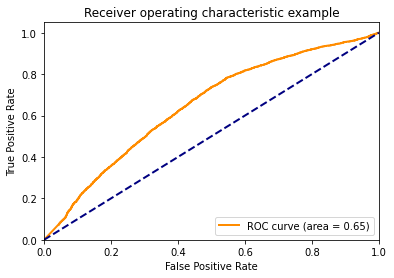

In [ ]:
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Prediction Scenario

In [8]:
window_size = (800,800)
def predict_gender(model, img):
  patches = sklearn_patches(img, window_size,100)
  show_img(patches[0])
  results = []
  for p in patches:
    m = cv2.resize(p,IMG_SIZE).reshape(1,IMG_SIZE[0],IMG_SIZE[1],1)
    m = m/255
    prediction = loaded_model.predict(m)
    results.append(loaded_model.predict(m)[0][0])
  ratio = np.sum(results) / len(results)
  if ratio > 0.5:
    print(f'pridected gender : Male | accuracy {ratio:.3}')
  else:
    print(f'pridected gender : Female | accuracy {(1-ratio):.3}')

Testing model on a random female text 

<Figure size 720x720 with 0 Axes>

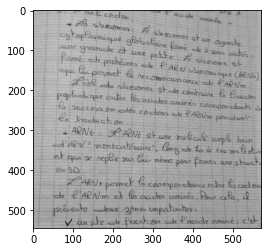

In [9]:
path = "/content/Female.jpg"
img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10,10))
show_img(img_array)

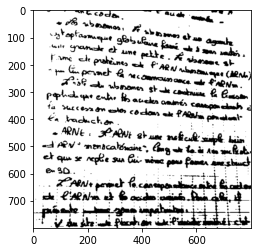

pridected gender : Female | accuracy 0.955


In [12]:
predict_gender(loaded_model, img_array)

Testing the model on a random male French text 

<Figure size 720x720 with 0 Axes>

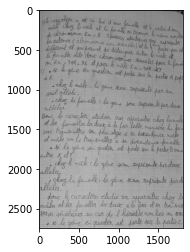

In [13]:
path = "/content/Male.jpg"
img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10,10))
show_img(img_array)

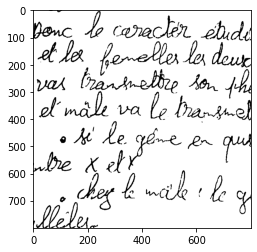

pridected gender : Male | accuracy 0.781


In [14]:
predict_gender(loaded_model, img_array)